In [2]:
import mne
import csv
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import savemat

from mne import io
from mne.minimum_norm import read_inverse_operator, compute_source_psd


In [118]:
a = np.arange(20)
mdic = {"a": a, "label": "experiment"}

savemat("matlab_matrix.mat", mdic)

In [14]:
# header = next(csvreader)
input_file = open('original_data/subjecta-concentrating-2.csv','r+')
reader_file = csv.reader(input_file)
raw_data = np.array(list(reader_file))
raw_data = np.delete(raw_data,5,1)
raw_data = np.delete(raw_data,0,1)
channel_mapping = list(raw_data[0,:])
raw_data = np.delete(raw_data,0,0).T
mdic = { "eeg": list(raw_data.astype(float))}
savemat("concentrating-sample.mat", mdic)
# ch_types = ['eeg'] * 4
# sampling_freq = 250
# info = mne.create_info(channel_mapping, ch_types=ch_types, sfreq=sampling_freq)
#
# a = np.arange(20)
# mdic = {"a": a, "label": "experiment"}

Effective window size : 8.192 (s)


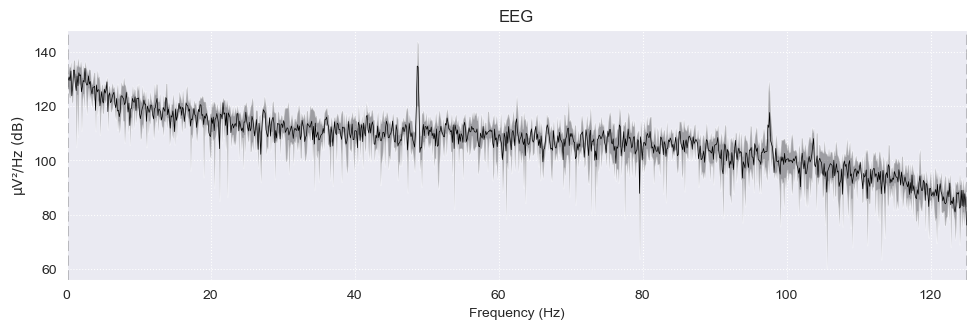

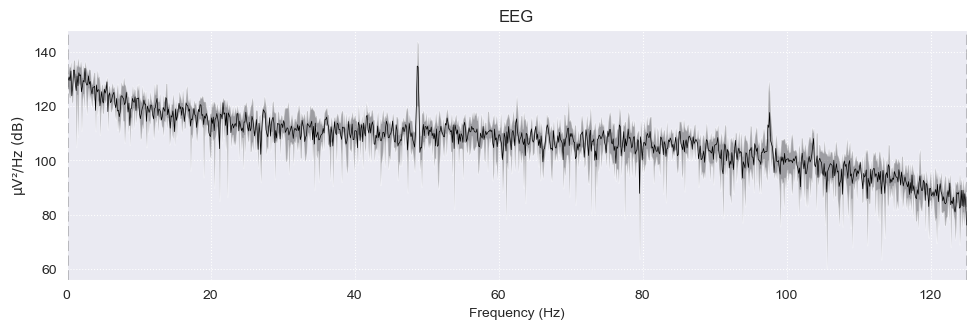

In [113]:
# Concentration
fmin, fmax = 2, 300  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

Effective window size : 8.192 (s)


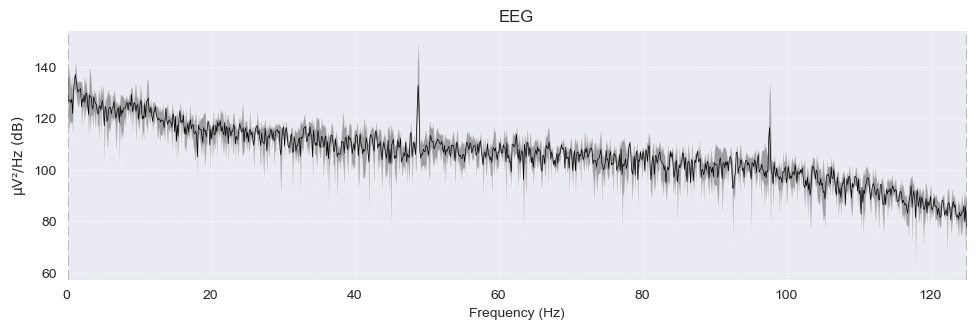

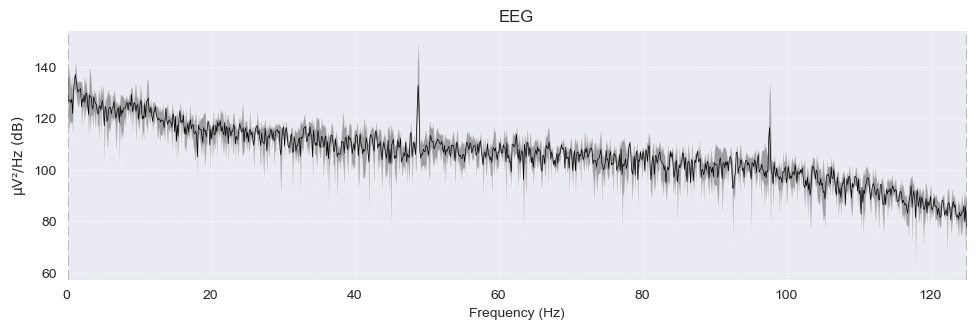

In [115]:
# Relax
fmin, fmax = 2, 300  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 8.192 (s)


/var/folders/1t/798ky1kx003ft5w1l83k6v9h0000gn/T/ipykernel_44823/4031920035.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  FFTed_signal.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);


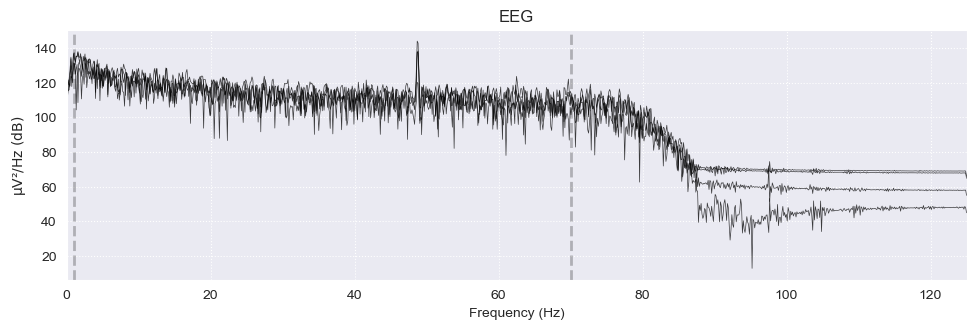

In [104]:
FFTed_signal = raw.filter(1, 70., fir_design='firwin')
picks = mne.pick_types(FFTed_signal.info, meg=False, eeg=True, eog=False,
                       stim=False)
FFTed_signal.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

Effective window size : 8.192 (s)


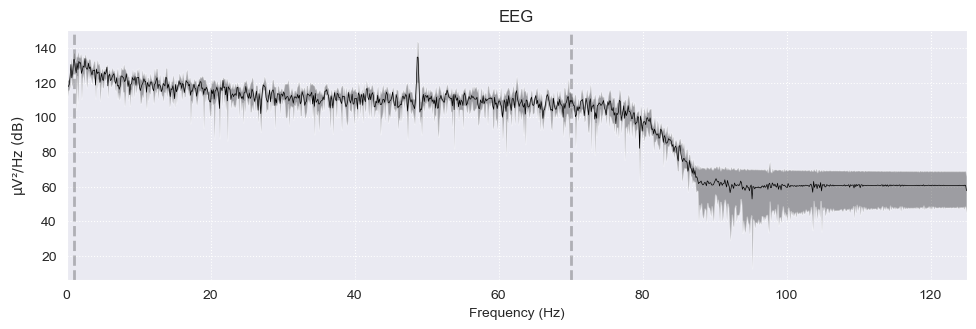

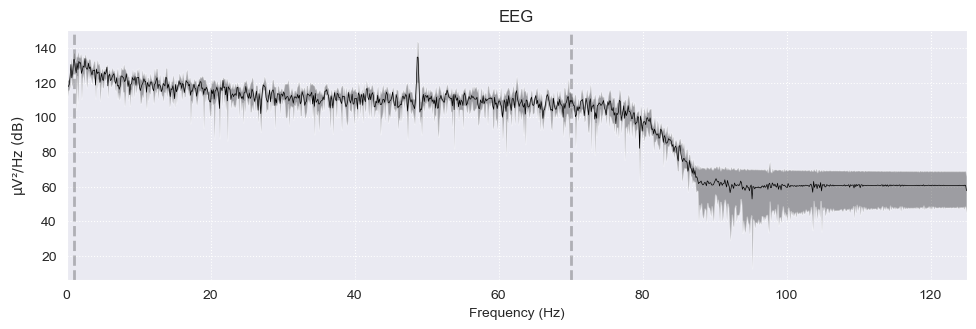

['0.00000', '0.00000', '0.03683', '0.09494']


Text(0.5, 1.0, 'EEGLAB channel projection')

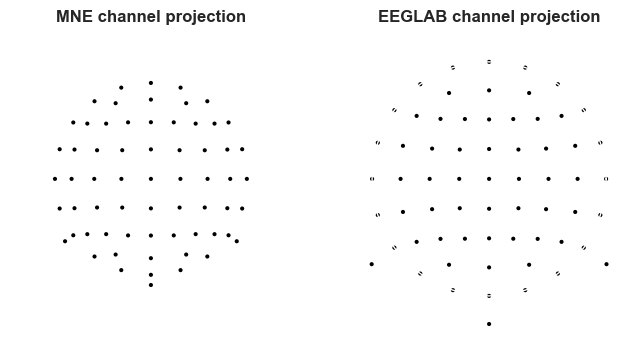

In [94]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data = rng.normal(size=(n_channels, 1)) * 1e-6
fake_evoked = mne.EvokedArray(data, fake_info)
fake_evoked.set_montage(biosemi_montage)

#
# first we obtain the 3d positions of selected channels
chs = ['Oz', 'Fpz', 'T7', 'T8']
# when the montage is set, it is transformed to the "head" coordinate frame
# that MNE uses internally, therefore we need to use
# ``fake_evoked.get_montage()`` to get these properly transformed coordinates
montage_head = fake_evoked.get_montage()
ch_pos = montage_head.get_positions()['ch_pos']
pos = np.stack([ch_pos[ch] for ch in chs])

# now we calculate the radius from T7 and T8 x position
# (we could use Oz and Fpz y positions as well)
radius = np.abs(pos[[2, 3], 0]).mean()

# then we obtain the x, y, z sphere center this way:
# x: x position of the Oz channel (should be very close to 0)
# y: y position of the T8 channel (should be very close to 0 too)
# z: average z position of Oz, Fpz, T7 and T8 (their z position should be the
#    the same, so we could also use just one of these channels), it should be
#    positive and somewhere around `0.03` (3 cm)
x = pos[0, 0]
y = pos[-1, 1]
z = pos[:, -1].mean()

# lets print the values we got:
print([f'{v:0.5f}' for v in [x, y, z, radius]])


# create a two-panel figure with some space for the titles at the top
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

# we plot the channel positions with default sphere - the mne way
fake_evoked.plot_sensors(axes=ax[0], show=False)

# in the second panel we plot the positions using the EEGLAB reference sphere
fake_evoked.plot_sensors(sphere=(x, y, z, radius), axes=ax[1], show=False)

# add titles
ax[0].set_title('MNE channel projection', fontweight='bold')
ax[1].set_title('EEGLAB channel projection', fontweight='bold')


Text(0.5, 1.0, 'EEGLAB')

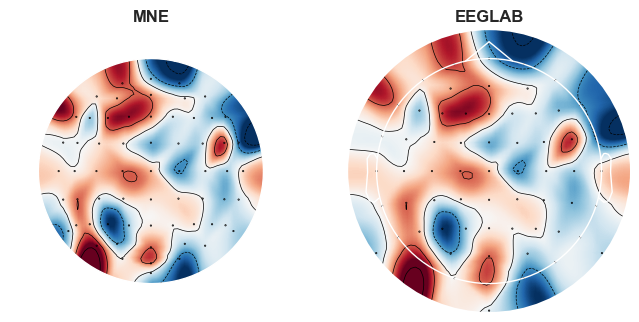

In [95]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

mne.viz.plot_topomap(fake_evoked.data[:, 0], fake_evoked.info, axes=ax[0],
                     show=False)
mne.viz.plot_topomap(fake_evoked.data[:, 0], fake_evoked.info, axes=ax[1],
                     show=False, sphere=(x, y, z, radius))

# add titles
ax[0].set_title('MNE', fontweight='bold')
ax[1].set_title('EEGLAB', fontweight='bold')